In [1]:
import pandas as pd
import urllib.request
import numpy as np
from IPython.display import display
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Data Collection #

For our analysis of cancer prediction using gene mutation and clinical data from patients, we will gather data from multiple sources. First we obtain the gene mutation data from the $cancer.gov$ website. Next we get the patient clinical data also from the $cancer.gov$ website. In our notebook, we store this data locally so that it does not have to downloaded if the notebook kernel is restarted and run multiple times.

In [4]:
# This downloads a 753 MB somatic mutations gzip file.  
# This will take about 1-5 mins depending on your
# connection speed.
mutations_filename = "./data/somatic_mutations.maf.gz"
if os.path.isfile(filename):
    print("Skipping download, as file %s is present" %(filename))
else:
    print('Downloading mutation data. 753 MB (may take a few minutes)...')
    url = 'http://api.gdc.cancer.gov/data/1c8cfe5f-e52d-41ba-94da-f15ea1337efc'  
    urllib.request.urlretrieve(url, filename)  
print("done.")

('./data/somatic_mutations.maf.gz', <http.client.HTTPMessage at 0x11ee2f2b0>)

done.


In [31]:
# This downloads an 18 MB patient clinical data file
patient_filename = "./data/patient_clinical_data.txt"
if os.path.isfile(filename):
    print("Skipping download, as file %s is present" %(filename))
else:
    print('Downloading clinical data ...')
    url = 'http://api.gdc.cancer.gov/data/0fc78496-818b-4896-bd83-52db1f533c5c'  
    urllib.request.urlretrieve(url, filename)  
print("done.")

Skipping download, as file ./data/patient_clinical_data.txt is present
done.


## Loading Gene Mutation Data ##

Here we read the gene mutation data. This data file contains many columns, but after careful curation, we have decided to consider the following colums:

1. **tumor_sample_barcode**: this contains the barcode with the first 12 characters identifying the patient
2. **gene**: this is the actual gene that has been mutated (for e.g. TACC2, JAKMIP3, PANX3)
3. **gene_type**: this indicates if the gene is protein coding or not.
4. **chromosome**  **start** **end** **Strand**: the chromosome, start position and end position tells us the location of the gene where the mutation is seen.  Strand indicates if it is on the forward or reverse strand of the DNA.
5. **variant_type**: this indicates if it is a single substitution mutation (SNP), a small deletion (DEL), or small insertion (INS), two nucleotide substitution (DNP), three nucleotide substitution (TNP), or more that three nucleotide substitution (ONP)
6. **variant_classification**: this indicates what kind of molecular effect that this mutation will have on the protein.  The most common classes indicate if the substitution causes a change to the amino acid (missense vs silent).  Nonsense mutations cause premature termination of the protein; frameshift mutations cause a misreading of the amino acid sequence.
7. **variant_impact**: this indicates how damaging the mutation -- HIGH, MODERATE, MODIFIER, or LOW.


In [43]:
# Load the mutations dataframe
print('Loading mutations dataframe ...')

mutations = pd.read_csv(mutations_filename, compression='gzip',
                        sep='\t',
                        usecols=['Tumor_Sample_Barcode','Hugo_Symbol', 'BIOTYPE',
                                'Chromosome', 'Start_Position',  'End_Position', 'Strand',
                                'Variant_Type',  'Variant_Classification', 'IMPACT' ])

print("done.")

# Set mutations index
mutations['row'] = np.arange(len(mutations))
mutations.set_index('row', inplace=True)

# Rename the columns to more consistent names
renamed_columns = { 'Tumor_Sample_Barcode': 'tumor_sample_barcode', 
                    'Hugo_Symbol': 'gene', 
                    'BIOTYPE': 'gene_type', 
                    'Chromosome': 'chromosome', 
                    'Start_Position': 'start', 
                    'End_Position': 'end', 
                    'Strand': 'strand', 
                    'Variant_Type': 'variant_type', 
                    'Variant_Classification': 'variant_classification', 
                    'IMPACT': 'variant_impact'}
mutations.rename(renamed_columns, inplace=True, axis=1)


print("\nMutations count:       ", mutations.tumor_sample_barcode.count())
print("Number of unique samples:", mutations.tumor_sample_barcode.nunique())
mutations.head(5)

Loading mutations dataframe ...


/Users/tonyd/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done.

Mutations count:        3600963
Number of unique samples: 10295


,gene,chromosome,start,end,strand,variant_classification,variant_type,tumor_sample_barcode,gene_type,variant_impact
row,,,,,,,,,,
0,TACC2,10,123810032,123810032,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
1,JAKMIP3,10,133967449,133967449,+,Silent,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,LOW
2,PANX3,11,124489539,124489539,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
3,SPI1,11,47380512,47380512,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE
4,NAALAD2,11,89868837,89868837,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE


The actual cancer type for each of the gene mutations above is kept in a different file. The entries are located at corresponding rows, so we use that to merge the cancer type from the labels.txt file.

In [27]:
# Read the cancer types.  These are the matching labels for the mutations file
print("Loading labels dataframe ...")
labels = pd.read_csv("./data/labels.txt", sep='\t')
labels.columns = ["cancer_type"]
labels['row'] = np.arange(len(labels))
labels.set_index('row', inplace=True)
print('Labels count:', labels.cancer_type.count())

Loading labels dataframe ...
Labels count: 3600963


As we can see, there are **3600963** data points in both the gene dataframe and the cancer label dataframe. So now we merge the label information into the main mutations dataframe. The idea is that when we bring in the patient information, we will go from a _row for each gene_ to a _row for each patient_, with all the gene mutation data for that patient added as columns. With this, the cancer type (label) will also gets included as a column. 

In [28]:
# Merge the labels with the mutations
mutations = mutations.merge(labels, left_on='row', right_on='row')
display(mutations.head(5))

,gene,chromosome,start,end,strand,variant_classification,variant_type,tumor_sample_barcode,gene_type,variant_impact,cancer_type
row,,,,,,,,,,,
0,TACC2,10,123810032,123810032,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM
1,JAKMIP3,10,133967449,133967449,+,Silent,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,LOW,GBM
2,PANX3,11,124489539,124489539,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM
3,SPI1,11,47380512,47380512,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM
4,NAALAD2,11,89868837,89868837,+,Missense_Mutation,SNP,TCGA-02-0003-01A-01D-1490-08,protein_coding,MODERATE,GBM


## Loading Patient Data##

Here we load the clinical data. This is data for patients for whom we collected the gene mutation data above. The patients are identified by $patient\_barcode$. We will use this field to populate the gene mutation data from the dataframe above in the table we are about to read. The clinical data has patient information such as gender and age at diagnosis.

Loading clinical dataframe ...
Clinical count 10956


,patient_barcode,cancer_type,gender,age_at_initial_pathologic_diagnosis
0,TCGA-OR-A5J1,ACC,MALE,58
1,TCGA-OR-A5J2,ACC,FEMALE,44
2,TCGA-OR-A5J3,ACC,FEMALE,23
3,TCGA-OR-A5J4,ACC,FEMALE,23
4,TCGA-OR-A5J5,ACC,MALE,30



Number of cancer types 32
Number of patients 10956


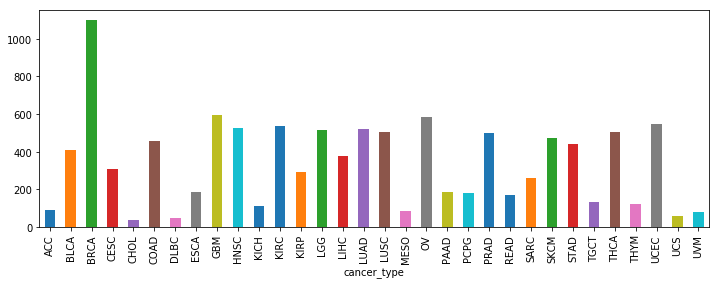

In [54]:
# Load the clinical data
print('Loading clinical dataframe ...')
clinical = pd.read_csv(patient_filename, sep='\t',
                        usecols=['bcr_patient_barcode', 'acronym', 'gender', 
                                 'age_at_initial_pathologic_diagnosis'])

# Rename the columns to more consistent names
renamed_columns = { 'bcr_patient_barcode': 'patient_barcode', 
                    'acronym': 'cancer_type' }
clinical.rename(renamed_columns, inplace=True, axis=1)

print('Clinical count', clinical.patient_barcode.count())
display(clinical.head(5))

# Get cancer types
cancer_types = clinical['cancer_type'].unique()
print("\nNumber of cancer types", len(cancer_types))

# Get number of cases per cancer type
group_by_patient = clinical.groupby(['cancer_type'])['patient_barcode'].nunique()
print("Number of patients", group_by_patient.sum())
group_by_patient.plot.bar(figsize=(12,4))

## Creating Merged Data ##

Now that we have both gene and cancer data in one dataframe, and the patient clinical data in another dataframe, we will use the **patient_barcode** to merge these into a single table. With this, we can drop the tumor_sample_barcode column, since it has served its purpose. Looking at the data, it seems like some patient data is missing from the gene data. Simultaneously, some data in the gene dataframe does not have corresponding clinical data. Hence our merged dataframe size will be lower than the original mutations dataframe size.

In [44]:
# Get the patient barcode.  This is what we will use to join the mutations to the clinical data
def parsePatientBarcode(tumor_sample_barcode):
        return tumor_sample_barcode[0:12]


mutations['patient_barcode'] = mutations['tumor_sample_barcode'].apply(parsePatientBarcode)
mutations = mutations.drop(['tumor_sample_barcode'], axis=1)
print("Number of unique patients:", mutations['patient_barcode'].nunique())

Number of unique patients: 10224


In [45]:
clinical['patient_barcode'].isnull().values.any()

False

In [46]:
missing_count = 0
gene_barcode_set = set(mutations.patient_barcode.unique())
for bc in gene_barcode_set:
    if bc not in set(clinical.patient_barcode.unique()):
        missing_count += 1
print("%d patients with gene data missing in clinical data" %missing_count)

216 patients with gene data missing in clinical data


In [52]:
merged = mutations.merge(clinical, left_on='patient_barcode', right_on='patient_barcode')
print('Merged mutations count:   ', merged.patient_barcode.count())
print('Number of unique patients:', merged.patient_barcode.nunique())
print('Number of cancer types:   ', merged.cancer_type.nunique())

Merged mutations count:    3570876
Number of unique patients: 10008
Number of cancer types:    32


In [53]:
# Write out new merged dataframe as csv file
print("Writing new csv file with merged mutations, clinical, and cancer types ...")
merged.to_csv("./data/somatic_mutations.csv")
print("done.")

Writing new csv file with merged mutations, clinical, and cancer types ...
done.
